### FA23 IN INFO H516 27452 Applied Cloud Computing for Data Intensive Sciences
## Project Final - Notebook
**Enchaining Fisheries Research Insights through Big Data Analytics**
### - Group 7
- Bhushan Shelke
- Hasaranga Jayathilake

### Setting up spark!

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [ ]:
import pyspark.sql
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.types import *
import json
from pyspark.sql.functions import col, sum, lit
from math import sqrt

In [ ]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import LDA
import warnings

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.mllib.classification import LogisticRegressionModel,LogisticRegressionWithLBFGS, SVMWithSGD, SVMModel,LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.mllib.clustering import *
from pyspark.ml.linalg import Vectors
from pyspark.mllib.tree import DecisionTree

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import ChiSquareTest

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GeneralizedLinearRegression

### Loading our data

In [ ]:
df = spark.read.format("csv").option("header","true").load("/content/drive/MyDrive/Spark_proj/ABL_Longline Sablefish Survey.csv")
df.createOrReplaceTempView("ABL_Survey")

In [ ]:
q1 = spark.sql("SELECT * FROM ABL_Survey LIMIT 5")
q1.show(truncate=False)

+-------------+-------------+--------------+------------+----------+---------------------+-----+-----------+-------------+----+-----------------------+-------------+-------------+-----------+-----------+--------------+------------+---------------+-------------+---------+------------------+--------------+------------+--------+-------+--------+------+-----------+------------+---------------------------------+--------------------+-----------+-----------------------+----------------+----+------------------+-------------------+-----+----------+-----------------+--------+--------------+-----------------------------------------------+--------------------------------------------------+-------------------+----------------+----------+---------------+---------+---------------+-------------------+
|cruise_number|vessel_number|station_number|species_code|catch_freq|common_name          |hachi|vessel_name|country      |year|haul_date              |start_hemi_ns|start_hemi_ew|end_hemi_ns|end_hemi_ew|

In [ ]:
q1 = spark.sql("SELECT start_hemi_ns, start_hemi_ew, end_hemi_ns, end_hemi_ew, AVG(catch_freq) FROM ABL_Survey GROUP BY start_hemi_ns, start_hemi_ew, end_hemi_ns, end_hemi_ew ")
q1.show(truncate=False)

+-------------+-------------+-----------+-----------+------------------+
|start_hemi_ns|start_hemi_ew|end_hemi_ns|end_hemi_ew|avg(catch_freq)   |
+-------------+-------------+-----------+-----------+------------------+
|n            |w            |n          |w          |4.9313624678663235|
|N            |W            |N          |W          |5.133610982457038 |
|N            |E            |N          |E          |4.927614763316634 |
|N            |E            |N          |W          |3.5269121813031163|
+-------------+-------------+-----------+-----------+------------------+



In [ ]:
q1 = spark.sql("SELECT DISTINCT(council_sablefish_management_area) FROM ABL_Survey")
q1.show(truncate=False)

+---------------------------------+
|council_sablefish_management_area|
+---------------------------------+
|West Yakutat                     |
|East Yakutat/Southeast           |
|Western Gulf of Alaska           |
|Central Gulf of Alaska           |
|Bering Sea                       |
|Aleutians                        |
+---------------------------------+



In [ ]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

null_counts.show()

+-------------+-------------+--------------+------------+----------+-----------+-----+-----------+-------+----+---------+-------------+-------------+-----------+-----------+--------------+------------+---------------+-------------+---------+---------------+--------------+------------+--------+-------+--------+------+-----------+------------+---------------------------------+--------------------+-----------+------------+----------------+----+------------------+-------------------+-------+----------+-----------------+--------+--------------+----------+----------+-------------------+----------------+----------+---------------+---------+---------------+-------------------+
|cruise_number|vessel_number|station_number|species_code|catch_freq|common_name|hachi|vessel_name|country|year|haul_date|start_hemi_ns|start_hemi_ew|end_hemi_ns|end_hemi_ew|set_start_time|set_end_time|haul_start_time|haul_end_time|soak_time|distance_fished|starting_depth|ending_depth|intrpdep|stratum|stratum2|baited|inef

#### Dropping columns with almost 50% missing values

In [ ]:
# Dropping columns having more than 50% of null values
columns_to_drop = ['gear_temperature','rpn_filter','mammal_sighting','tdr_depth','depredated_freq','non_depredated_freq']  # Replace with your actual column names
df = df.drop(*columns_to_drop)

#### Changing datatype of numerical columns

In [ ]:
df = df.withColumn("distance_fished", col("distance_fished").cast("float"))
df = df.withColumn("catch_freq", col("catch_freq").cast("float"))
df = df.withColumn("hachi", col("hachi").cast("float"))
df = df.withColumn("year", col("year").cast("float"))
df = df.withColumn("soak_time", col("soak_time").cast("float"))
df = df.withColumn("starting_depth", col("starting_depth").cast("float"))
df = df.withColumn("ending_depth", col("ending_depth").cast("float"))
df = df.withColumn("surface_temperature", col("surface_temperature").cast("float"))

#### Few Spark SQL operations

In [ ]:
df.createOrReplaceTempView("ABL_Survey")

In [ ]:
q1 = spark.sql("SELECT DISTINCT(year) FROM ABL_Survey")
q1.show(100)

+------+
|  year|
+------+
|1999.0|
|1992.0|
|2001.0|
|1997.0|
|1995.0|
|1988.0|
|1991.0|
|1990.0|
|1993.0|
|1989.0|
|1983.0|
|1981.0|
|1980.0|
|1998.0|
|2000.0|
|1996.0|
|1986.0|
|1994.0|
|1985.0|
|1987.0|
|1979.0|
|1982.0|
|2004.0|
|1984.0|
|2005.0|
|2010.0|
|2003.0|
|2011.0|
|2009.0|
|2008.0|
|2006.0|
|2007.0|
|2002.0|
|2016.0|
|2012.0|
|2014.0|
|2017.0|
|2013.0|
|2015.0|
+------+



In [ ]:
q1 = spark.sql("SELECT max(catch_freq) FROM ABL_Survey").show()


+---------------+
|max(catch_freq)|
+---------------+
|           86.0|
+---------------+



### Data viz.


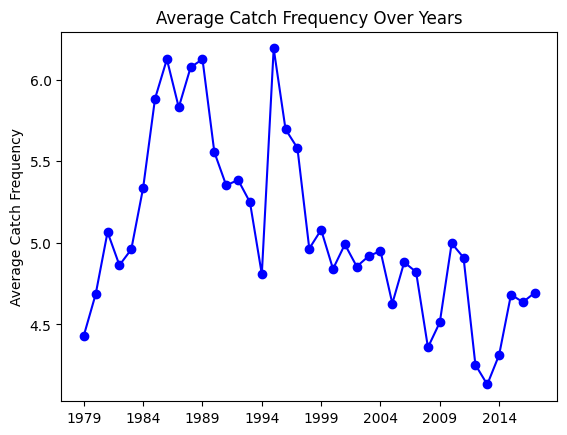

In [ ]:
# catch_freq vs year
q1 = spark.sql("SELECT year, AVG(catch_freq) as Catch FROM ABL_Survey GROUP BY year ORDER BY year")
viz1 = q1.toPandas()
plt.plot(viz1['year'],viz1['Catch'],marker='o', linestyle='-', color='b')
plt.title('Average Catch Frequency Over Years')
plt.ylabel('Average Catch Frequency')
plt.xticks(viz1['year'][::5])
plt.show()

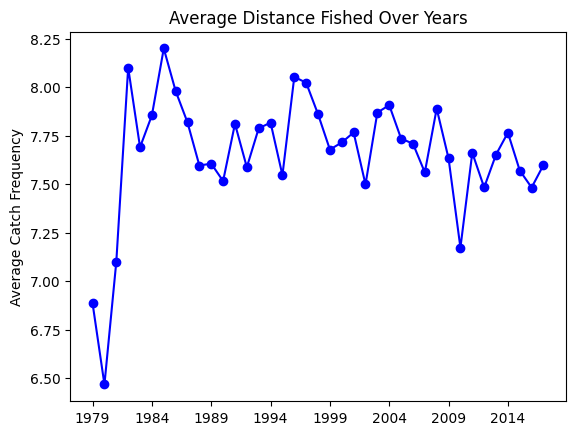

In [ ]:
# catch_freq vs year
q1 = spark.sql("SELECT year, AVG(distance_fished) as distance FROM ABL_Survey GROUP BY year ORDER BY year")
viz1 = q1.toPandas()
plt.plot(viz1['year'],viz1['distance'],marker='o', linestyle='-', color='b')
plt.title('Average Distance Fished Over Years')
plt.ylabel('Average Catch Frequency')
plt.xticks(viz1['year'][::5])
plt.show()

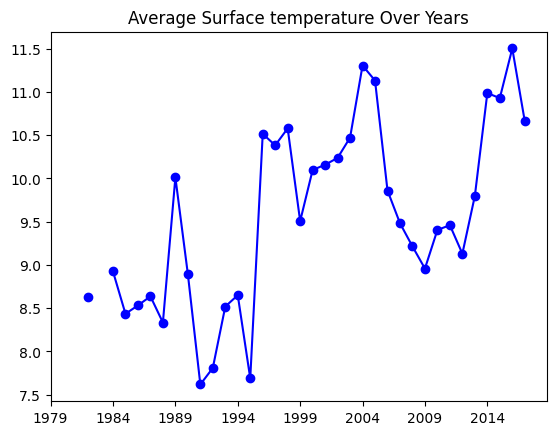

In [ ]:
# catch_freq vs year
q1 = spark.sql("SELECT year, AVG(surface_temperature) as temp FROM ABL_Survey GROUP BY year ORDER BY year")
viz1 = q1.toPandas()
plt.plot(viz1['year'],viz1['temp'],marker='o', linestyle='-', color='b')
plt.title('Average Surface temperature Over Years')
plt.xticks(viz1['year'][::5])
plt.show()

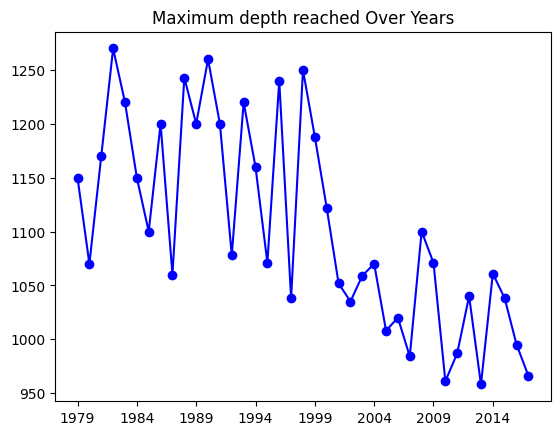

In [ ]:
# catch_freq vs year
q1 = spark.sql("SELECT year, MAX(ending_depth) as depth FROM ABL_Survey GROUP BY year ORDER BY year")
viz1 = q1.toPandas()
plt.plot(viz1['year'],viz1['depth'],marker='o', linestyle='-', color='b')
plt.title('Maximum depth reached Over Years')
plt.xticks(viz1['year'][::5])
plt.show()

### Time series prediction for different regions

In [ ]:
def time_series_analysis(q1):
  import statsmodels.api as sm

  pandas_df = q1.toPandas()

  time_column = 'year'
  value_columns = ['avg(catch_freq)','AVG(distance_fished)', 'AVG(hachi)', 'AVG(soak_time)', 'AVG(starting_depth)', 'AVG(ending_depth)', 'AVG(intrpdep)']


  # Renaming columns as required by statsmodels
  statsmodels_df = pandas_df.rename(
        columns={time_column: 'ds', **{col: f'y_{i}' for i, col in enumerate(value_columns)}}
    )

  statsmodels_df.set_index('ds', inplace=True)

  # ARIMA model
  model = sm.tsa.ARIMA(statsmodels_df['y_0'], order=(1, 1, 1))  # Adjust order as needed
  result = model.fit()

  # Forecasting future values
  forecast_steps = 5
  forecast = result.get_forecast(steps=forecast_steps)

  # Extracting forecasted values
  forecast_values = forecast.predicted_mean
  warnings.filterwarnings("ignore")

  return forecast_values

In [ ]:
# WEST YAKUTAT
q1 = spark.sql("SELECT year ,AVG(catch_freq),AVG(distance_fished), AVG(hachi), AVG(soak_time), AVG(starting_depth), AVG(ending_depth), AVG(intrpdep) FROM ABL_Survey  WHERE council_sablefish_management_area = 'West Yakutat' GROUP BY year ORDER BY year")
time_series_analysis(q1)

2018-01-01    4.619464
2019-01-01    4.665190
2020-01-01    4.703936
2021-01-01    4.736769
2022-01-01    4.764591
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
# EAST YAKUTAT / SOUTHEAST
q1 = spark.sql("SELECT year ,AVG(catch_freq),AVG(distance_fished), AVG(hachi), AVG(soak_time), AVG(starting_depth), AVG(ending_depth), AVG(intrpdep) FROM ABL_Survey  WHERE council_sablefish_management_area = 'East Yakutat/Southeast' GROUP BY year ORDER BY year")
time_series_analysis(q1)

2018-01-01    3.621079
2019-01-01    3.772394
2020-01-01    3.621097
2021-01-01    3.772376
2022-01-01    3.621115
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
# WESTERN GULF OF ALASKA
q1 = spark.sql("SELECT year ,AVG(catch_freq),AVG(distance_fished), AVG(hachi), AVG(soak_time), AVG(starting_depth), AVG(ending_depth), AVG(intrpdep) FROM ABL_Survey  WHERE council_sablefish_management_area = 'Western Gulf of Alaska' GROUP BY year ORDER BY year")
time_series_analysis(q1)

2018-01-01    6.600812
2019-01-01    6.602177
2020-01-01    6.602120
2021-01-01    6.602122
2022-01-01    6.602122
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
# CENTRAL GULF OF ALASKA
q1 = spark.sql("SELECT year ,AVG(catch_freq),AVG(distance_fished), AVG(hachi), AVG(soak_time), AVG(starting_depth), AVG(ending_depth), AVG(intrpdep) FROM ABL_Survey  WHERE council_sablefish_management_area = 'Central Gulf of Alaska' GROUP BY year ORDER BY year")
time_series_analysis(q1)

2018-01-01    4.606544
2019-01-01    4.764194
2020-01-01    4.625121
2021-01-01    4.747806
2022-01-01    4.639578
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
# BERING SEA
q1 = spark.sql("SELECT year ,AVG(catch_freq),AVG(distance_fished), AVG(hachi), AVG(soak_time), AVG(starting_depth), AVG(ending_depth), AVG(intrpdep) FROM ABL_Survey  WHERE council_sablefish_management_area = 'Bering Sea' GROUP BY year ORDER BY year")
time_series_analysis(q1)

27    4.408145
28    4.422670
29    4.432742
30    4.439728
31    4.444572
Name: predicted_mean, dtype: float64

In [ ]:
# ALEUTIANS
q1 = spark.sql("SELECT year ,AVG(catch_freq),AVG(distance_fished), AVG(hachi), AVG(soak_time), AVG(starting_depth), AVG(ending_depth), AVG(intrpdep) FROM ABL_Survey  WHERE council_sablefish_management_area = 'Aleutians' GROUP BY year ORDER BY year")
time_series_analysis(q1)

27    4.781598
28    4.836491
29    4.823145
30    4.826390
31    4.825601
Name: predicted_mean, dtype: float64

### Prediction using Linear Regression model for different regions

In [ ]:
from pyspark.ml.regression import LinearRegression


def linear_regression(ml1):
    # Casting columns to float
    ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
    ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
    ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
    ml1 = ml1.withColumn("year", col("year").cast("float"))
    ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
    ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
    ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
    ml1 = ml1.withColumn("intrpdep", col("intrpdep").cast("float"))
    ml1 = ml1.withColumn("depth_time", col("depth_time").cast("float"))

    # Preparing the data
    feature_columns = ["year", "distance_fished", "hachi", "soak_time", "starting_depth", "ending_depth"]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_assembled = assembler.transform(ml1)

    # Selecting features and target variable
    data = df_assembled.select("features", "catch_freq")

    # Splitting the data into training and testing sets
    (train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)

    # Defining the Linear Regression model
    lr = LinearRegression(labelCol="catch_freq", featuresCol="features")

    # Training the model
    model = lr.fit(train_data)

    # Making predictions on the test set
    predictions = model.transform(test_data)

    # Evaluating the model
    evaluator = RegressionEvaluator(labelCol="catch_freq", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)
    print("Mean Squared Error (MSE):", mse)

    rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
    print("Root Mean Squared Error (RMSE):", rmse)

    mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
    print("Mean Absolute Error (MAE):", mae)

    r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    print("R-squared (R2):", r2)

    # Creating new data with years to predict
    years_to_predict = [2018.0, 2019.0, 2020.0, 2021.0, 2022.0]
    for year in years_to_predict:
      new_data_df = spark.createDataFrame([(year,) for _ in range(len(years_to_predict))], ["year"])

      # Cross join with other relevant columns
      new_data_df = new_data_df.crossJoin(ml1.select("distance_fished", "hachi", "soak_time", "starting_depth", "ending_depth"))

      df_assembled_new = assembler.transform(new_data_df)

      data_new = df_assembled_new.select("features")

      predictions = model.transform(data_new)


      predictions.createOrReplaceTempView("pred")


      random_row = spark.sql("SELECT AVG(prediction) FROM pred ")


      random_row.show(truncate=False)


    return "Executed..."


In [ ]:
# WEST YAKUTAT
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'West Yakutat' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
linear_regression(ml1)

Mean Squared Error (MSE): 34.20927553126478
Root Mean Squared Error (RMSE): 5.8488695943117746
Mean Absolute Error (MAE): 4.235607963605795
R-squared (R2): 0.0682659069650251
+----------------+
|avg(prediction) |
+----------------+
|3.89882280293675|
+----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|3.832501655186611|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|3.766180507436521|
+-----------------+

+------------------+
|avg(prediction)   |
+------------------+
|3.6998593596863607|
+------------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|3.633538211936284|
+-----------------+



'Executed...'

In [ ]:
# ALEUTIANS
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Aleutians' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
linear_regression(ml1)

Mean Squared Error (MSE): 35.96564614197852
Root Mean Squared Error (RMSE): 5.997136495193228
Mean Absolute Error (MAE): 4.235873280480026
R-squared (R2): 0.0033156858360682273
+-----------------+
|avg(prediction)  |
+-----------------+
|4.297422720280335|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|4.277409090511644|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|4.257395460742889|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|4.237381830973991|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|4.217368201205287|
+-----------------+



'Executed...'

In [ ]:
# BERING SEA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Bering Sea' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
linear_regression(ml1)

Mean Squared Error (MSE): 28.800619647382113
Root Mean Squared Error (RMSE): 5.3666208779251505
Mean Absolute Error (MAE): 3.7847744712021125
R-squared (R2): 0.01375827501044935
+-----------------+
|avg(prediction)  |
+-----------------+
|3.698594562889349|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|3.663351168608623|
+-----------------+

+------------------+
|avg(prediction)   |
+------------------+
|3.6281077743278956|
+------------------+

+------------------+
|avg(prediction)   |
+------------------+
|3.5928643800471884|
+------------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|3.557620985766486|
+-----------------+



'Executed...'

In [ ]:
# EAST YAKUTAT / SOUTHEAST
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'East Yakutat/Southeast' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
linear_regression(ml1)

Mean Squared Error (MSE): 34.28599542393624
Root Mean Squared Error (RMSE): 5.855424444387976
Mean Absolute Error (MAE): 4.250325772656301
R-squared (R2): 0.05523155368018484
+------------------+
|avg(prediction)   |
+------------------+
|3.0944797821949037|
+------------------+

+------------------+
|avg(prediction)   |
+------------------+
|2.9995790024393214|
+------------------+

+------------------+
|avg(prediction)   |
+------------------+
|2.9046782226837897|
+------------------+

+------------------+
|avg(prediction)   |
+------------------+
|2.8097774429282403|
+------------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|2.714876663172699|
+-----------------+



'Executed...'

In [ ]:
# WESTERN GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Western Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
linear_regression(ml1)

Mean Squared Error (MSE): 49.12391101968027
Root Mean Squared Error (RMSE): 7.008845198724272
Mean Absolute Error (MAE): 5.311962066210129
R-squared (R2): 0.019999919050778803
+-----------------+
|avg(prediction)  |
+-----------------+
|5.720838873873236|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|5.696470629731763|
+-----------------+

+------------------+
|avg(prediction)   |
+------------------+
|5.6721023855903265|
+------------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|5.647734141448842|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|5.623365897307349|
+-----------------+



'Executed...'

In [ ]:
# CENTRAL GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Central Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
linear_regression(ml1)

Mean Squared Error (MSE): 32.71622433056527
Root Mean Squared Error (RMSE): 5.719809815943645
Mean Absolute Error (MAE): 4.298742868322181
R-squared (R2): 0.042015014226782665
+-----------------+
|avg(prediction)  |
+-----------------+
|4.686233695758373|
+-----------------+

+----------------+
|avg(prediction) |
+----------------+
|4.64608446503007|
+----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|4.605935234301818|
+-----------------+

+-----------------+
|avg(prediction)  |
+-----------------+
|4.565786003573546|
+-----------------+

+------------------+
|avg(prediction)   |
+------------------+
|4.5256367728453455|
+------------------+



'Executed...'

### Prediction using Random Forest Regression for different regions

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
def rf(ml1):
  ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
  ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
  ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
  ml1 = ml1.withColumn("year", col("year").cast("float"))
  ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
  ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
  ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
  ml1 = ml1.withColumn("intrpdep", col("intrpdep").cast("float"))
  ml1 = ml1.withColumn("depth_time", col("depth_time").cast("float"))

  # Preparing the data
  feature_columns = ["year", "distance_fished","hachi", "soak_time", "starting_depth", "ending_depth"]
  assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
  df_assembled = assembler.transform(ml1)

  # Selecting features and target variable
  data = df_assembled.select("features", "catch_freq")

  # Splitting the data into training and testing sets
  (train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)


  rf = RandomForestRegressor(labelCol="catch_freq", featuresCol="features")

  # Training the model
  model = rf.fit(train_data)

  # Making predictions on the test set
  predictions = model.transform(test_data)

  # Evaluating the model
  evaluator = RegressionEvaluator(labelCol="catch_freq", predictionCol="prediction", metricName="mse")
  mse = evaluator.evaluate(predictions)
  print("Mean Squared Error (MSE):", mse)

  rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
  print("Root Mean Squared Error (RMSE):", rmse)

  mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
  print("Mean Absolute Error (MAE):", mae)

  r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
  print("R-squared (R2):", r2)


  # Creating new data with years to predict
  years_to_predict = [2018.0, 2019.0, 2020.0, 2021.0, 2022.0]
  for year in years_to_predict:
      new_data_df = spark.createDataFrame([(year,) for _ in range(len(years_to_predict))], ["year"])

      # Cross join with other relevant columns
      new_data_df = new_data_df.crossJoin(ml1.select("distance_fished", "hachi", "soak_time", "starting_depth", "ending_depth"))

      df_assembled_new = assembler.transform(new_data_df)

      data_new = df_assembled_new.select("features")

      predictions = model.transform(data_new)

      predictions.createOrReplaceTempView("pred")

      random_row = spark.sql("SELECT AVG(prediction) FROM pred ")

      random_row.show(truncate=False)

  return "Executed..."

In [ ]:
# WEST YAKUTAT
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'West Yakutat' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
rf(ml1)

In [ ]:
# ALEUTIANS
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Aleutians' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
rf(ml1)

In [ ]:
# BERING SEA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Bering Sea' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
rf(ml1)

In [ ]:
# EAST YAKUTAT/ SOUTHEAST
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'East Yakutat/Southeast' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
rf(ml1)

In [ ]:
# WESTERN GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Western Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
rf(ml1)

In [ ]:
# CENTRAL GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Central Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
rf(ml1)

### Prediction using GBT Regressor for different regions

In [ ]:
def gbt_regression(ml1):
  ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
  ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
  ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
  ml1 = ml1.withColumn("year", col("year").cast("float"))
  ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
  ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
  ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
  ml1 = ml1.withColumn("intrpdep", col("intrpdep").cast("float"))
  ml1 = ml1.withColumn("depth_time", col("depth_time").cast("float"))

  # Preparing the data
  feature_columns = ["year", "distance_fished","hachi", "soak_time", "starting_depth", "ending_depth"]
  assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
  df_assembled = assembler.transform(ml1)

  # Selecting features and target variable
  data = df_assembled.select("features", "catch_freq")

  # Splitting the data into training and testing sets
  (train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)

  # Using GBT Regression model
  gbt = GBTRegressor(labelCol="catch_freq", featuresCol="features", maxIter=10)

  # Training the model
  model = gbt.fit(train_data)

  # Making predictions on the test set
  predictions = model.transform(test_data)

  # Evaluating the model
  evaluator = RegressionEvaluator(labelCol="catch_freq", predictionCol="prediction", metricName="mse")
  mse = evaluator.evaluate(predictions)
  print("Mean Squared Error (MSE):", mse)

  rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
  print("Root Mean Squared Error (RMSE):", rmse)

  mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
  print("Mean Absolute Error (MAE):", mae)

  r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
  print("R-squared (R2):", r2)


  # Creating new data with years to predict
  years_to_predict = [2018.0, 2019.0, 2020.0, 2021.0, 2022.0]
  for year in years_to_predict:
      new_data_df = spark.createDataFrame([(year,) for _ in range(len(years_to_predict))], ["year"])

      # Cross join with other relevant columns
      new_data_df = new_data_df.crossJoin(ml1.select("distance_fished", "hachi", "soak_time", "starting_depth", "ending_depth"))

      df_assembled_new = assembler.transform(new_data_df)

      data_new = df_assembled_new.select("features")

      predictions = model.transform(data_new)


      predictions.createOrReplaceTempView("pred")

      random_row = spark.sql("SELECT AVG(prediction) FROM pred ")

      random_row.show(truncate=False)

  return "Executed..."

In [ ]:
# WEST YAKUTAT
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'West Yakutat' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
df = gbt_regression(ml1)

In [ ]:
# ALEUTIANS
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Aleutians' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
gbt_regression(ml1)

In [ ]:
# BERING SEA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Bering Sea' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
gbt_regression(ml1)

In [ ]:
# EAST YAKUTAT/ SOUTHEAST
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'East Yakutat/Southeast' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
gbt_regression(ml1)

In [ ]:
# WESTERN GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Western Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
gbt_regression(ml1)

In [ ]:
# CENTRAL GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Central Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
gbt_regression(ml1)

### Prediction Using Generalized Linear Regression model

In [ ]:
def glm(ml1):
  ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
  ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
  ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
  ml1 = ml1.withColumn("year", col("year").cast("float"))
  ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
  ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
  ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
  ml1 = ml1.withColumn("intrpdep", col("intrpdep").cast("float"))
  ml1 = ml1.withColumn("depth_time", col("depth_time").cast("float"))

  # Preparing the data
  feature_columns = ["year", "distance_fished","hachi", "soak_time", "starting_depth", "ending_depth"]
  assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
  df_assembled = assembler.transform(ml1)

  # Selecting features and target variable
  data = df_assembled.select("features", "catch_freq")

  # Splitting the data into training and testing sets
  (train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)

  # Using GBT Regression model
  glr = GeneralizedLinearRegression(labelCol="catch_freq", featuresCol="features", family="gaussian", link="identity")

  # Training the model
  model = glr.fit(train_data)

  # Making predictions on the test set
  predictions = model.transform(test_data)

  # Evaluating the model
  evaluator = RegressionEvaluator(labelCol="catch_freq", predictionCol="prediction", metricName="mse")
  mse = evaluator.evaluate(predictions)
  print("Mean Squared Error (MSE):", mse)

  rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
  print("Root Mean Squared Error (RMSE):", rmse)

  mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
  print("Mean Absolute Error (MAE):", mae)

  r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
  print("R-squared (R2):", r2)

  # Creating new data with years to predict
  # Creating new data with years to predict
  years_to_predict = [2018.0, 2019.0, 2020.0, 2021.0, 2022.0]
  for year in years_to_predict:
      new_data_df = spark.createDataFrame([(year,) for _ in range(len(years_to_predict))], ["year"])

      # Cross join with other relevant columns
      new_data_df = new_data_df.crossJoin(ml1.select("distance_fished", "hachi", "soak_time", "starting_depth", "ending_depth"))

      df_assembled_new = assembler.transform(new_data_df)

      data_new = df_assembled_new.select("features")

      predictions = model.transform(data_new)

      predictions.createOrReplaceTempView("pred")


      random_row = spark.sql("SELECT AVG(prediction) FROM pred ")


      random_row.show(truncate=False)

  return "Executed..."

In [ ]:
# WEST YAKUTAT
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'West Yakutat' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
glm(ml1)

In [ ]:
# ALEUTIANS
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Aleutians' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
glm(ml1)

In [ ]:
# BERING SEA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Bering Sea' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
glm(ml1)

In [ ]:
# EAST YAKUTAT/SOUTHEAST
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'East Yakutat/Southeast' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
glm(ml1)

In [ ]:
# WESTERN GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Western Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
glm(ml1)

In [ ]:
# CENTRAL GULF OF ALASKA
q1 = spark.sql("SELECT year ,catch_freq, distance_fished, hachi, soak_time, starting_depth, ending_depth, intrpdep, depth_time FROM ABL_Survey  WHERE council_sablefish_management_area = 'Central Gulf of Alaska' AND soak_time IS NOT NULL ORDER BY year")
ml1 = q1
glm(ml1)

### Surface temp vs Catch freq


In [ ]:
q1 = spark.sql("SELECT catch_freq, surface_temperature FROM ABL_Survey WHERE surface_temperature IS NOT NULL")
q1.show()
ml1 = q1

+----------+-------------------+
|catch_freq|surface_temperature|
+----------+-------------------+
|       1.0|                7.5|
|      12.0|                7.5|
|       1.0|                7.5|
|       2.0|                7.5|
|       1.0|                7.5|
|      11.0|                7.5|
|       3.0|                7.5|
|      11.0|                7.5|
|       5.0|                7.5|
|       5.0|                7.5|
|       1.0|                7.5|
|       2.0|                7.5|
|       1.0|                7.5|
|      11.0|                7.5|
|       1.0|                7.5|
|      12.0|                7.5|
|       5.0|                7.5|
|       8.0|                7.5|
|       2.0|                7.5|
|       2.0|                7.5|
+----------+-------------------+
only showing top 20 rows



In [ ]:
def parsePoint(row):
    catch_freq = float(row['catch_freq'])
    surface_temperature = float(row['surface_temperature'])
    #distance_fished = float(row['distance_fished'])
    #soak_time = (row['soak_time'])
    #depth = float(row['depth'])

    label = catch_freq
    features = ([surface_temperature])

    return LabeledPoint(label, features)

In [ ]:
 ml1 = ml1.rdd
 ml1 = ml1.map(parsePoint)


In [ ]:
train, test = ml1.randomSplit([0.8, 0.2])
model = LinearRegressionWithSGD.train(train, iterations=1000, step=0.00000001)

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/mllib/regression.py:301: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn(


In [ ]:
Predictions = test.map(lambda x: (x.label, model.predict(x.features)))

In [ ]:
SE = Predictions.map(lambda x: (x[0] - x[1])**2)
MSE = SE.reduce(lambda x, y: x + y) / Predictions.count()
RMSE = sqrt(MSE)
print("Root Mean Squared Error = " + str(RMSE))

Root Mean Squared Error = 7.869262534082909


In [ ]:
new_surface_temperature = 7.5
model.predict([new_surface_temperature])

6.233860917791361e-06

### Distance fished vs Catch freq

In [ ]:
q1 = spark.sql("SELECT catch_freq, distance_fished FROM ABL_Survey")
ml1 = q1
print(q1.show(truncate = False))

+----------+------------------+
|catch_freq|distance_fished   |
+----------+------------------+
|1.0       |8.6000003814697266|
|7.0       |8.6000003814697266|
|3.0       |8.6000003814697266|
|3.0       |8.6000003814697266|
|17.0      |8.6000003814697266|
|1.0       |8.6000003814697266|
|1.0       |8.6000003814697266|
|1.0       |8.6000003814697266|
|13.0      |8.6000003814697266|
|1.0       |8.6000003814697266|
|2.0       |8.6000003814697266|
|25.0      |8.6000003814697266|
|1.0       |8.6000003814697266|
|6.0       |8.6000003814697266|
|10.0      |8.6000003814697266|
|5.0       |8.6000003814697266|
|9.0       |8.6000003814697266|
|1.0       |8.6000003814697266|
|13.0      |8.6000003814697266|
|1.0       |8.6000003814697266|
+----------+------------------+
only showing top 20 rows

None


In [ ]:
def parsePoint(row):
    catch_freq = float(row['catch_freq'])
    # Check if 'surface_temperature' is None and handle it accordingly
    #surface_temperature = float(row['surface_temperature']) if row['surface_temperature'] is not None else 0.0
    distance_fished = float(row['distance_fished'])
    #soak_time = (row['soak_time'])
    #depth = float(row['depth'])


    # Assuming 'catch_freq' is the label
    label = catch_freq
    features = ([distance_fished])

    return LabeledPoint(label, features)


In [ ]:
ml1 = ml1.rdd
parsedml1 = ml1.map(parsePoint)
train, test = parsedml1.randomSplit([0.8, 0.2])
model = LinearRegressionWithSGD.train(train, iterations=1000, step=0.00000001)
valuesAndPreds = test.map(lambda x: (x.label, model.predict(x.features)))
SE = valuesAndPreds.map(lambda x: (x[0] - x[1])**2)
MSE = SE.reduce(lambda x, y: x + y) / valuesAndPreds.count()
RMSE = sqrt(MSE)
print("Root Mean Squared Error = " + str(RMSE))

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/mllib/regression.py:301: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn(


Root Mean Squared Error = 7.881644305485354


In [ ]:
model.predict([9.000])

6.128080347357708e-06

### Stratum vs catch freq

In [ ]:
q1 = spark.sql("SELECT stratum, stratumdescription, AVG(catch_freq) as Catch FROM ABL_Survey GROUP BY stratum, stratumdescription ORDER BY stratum ")
print(q1.show(truncate = False))

+-------+------------------+------------------+
|stratum|stratumdescription|Catch             |
+-------+------------------+------------------+
|1      |0-100m            |6.669200144770177 |
|2      |101-200m          |4.996531862642849 |
|3      |201-300m          |4.197991319269204 |
|4      |301-400m          |4.225113314873392 |
|5      |401-600m          |5.4844957166673876|
|6      |601-800m          |6.466758031430258 |
|7      |801-1000m         |6.1130393038078115|
|8      |1001-1200m        |5.9008159102498725|
|9      |1201m +           |6.675675675675675 |
+-------+------------------+------------------+

None


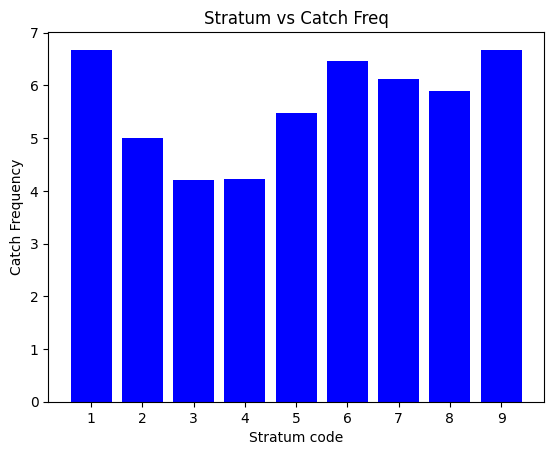

In [ ]:
viz1 = q1.toPandas()
plt.bar(x= viz1['stratum'],height = viz1['Catch'],color='b')
plt.title('Stratum vs Catch Freq')
plt.xlabel("Stratum code")
plt.ylabel('Catch Frequency')
plt.xticks(viz1['stratum'])
plt.show()

### Geographic area vs catch freq

In [ ]:
q1 = spark.sql("SELECT council_sablefish_management_area,geographic_area_name,AVG(catch_freq) FROM ABL_Survey GROUP BY council_sablefish_management_area, geographic_area_name ORDER BY AVG(catch_freq) DESC")
q1.show(40)

+---------------------------------+--------------------+------------------+
|council_sablefish_management_area|geographic_area_name|   avg(catch_freq)|
+---------------------------------+--------------------+------------------+
|             Western Gulf of A...|      Shumagin Slope| 6.150852201513171|
|             Central Gulf of A...|      Chirikof slope| 5.971107333051388|
|             East Yakutat/Sout...|       Spencer Gully| 5.867002024611532|
|             Central Gulf of A...|        Kodiak slope|5.7655561627673455|
|                        Aleutians|  NW Aleutians slope|   5.7220270020344|
|                     West Yakutat|     W Yakutat slope| 5.388402361803308|
|             East Yakutat/Sout...|     Southeast slope| 5.361888564550954|
|                       Bering Sea|      Bering 4 slope| 5.066280904849327|
|             East Yakutat/Sout...|  East Yakutat slope| 4.917345996438105|
|             Western Gulf of A...|      Shumagin Gully| 4.853327681220856|
|           

In [ ]:
q1 = spark.sql("SELECT geographic_area_name, AVG(catch_freq) FROM ABL_Survey GROUP BY geographic_area_name ORDER BY AVG(catch_freq) DESC")
q1.show(40)

+--------------------+------------------+
|geographic_area_name|   avg(catch_freq)|
+--------------------+------------------+
|      Shumagin Slope| 6.150852201455093|
|      Chirikof slope| 5.971107332915743|
|       Spencer Gully|  5.86700202441568|
|        Kodiak slope|5.7655561625489025|
|  NW Aleutians slope|   5.7220270020344|
|     W Yakutat slope| 5.388402361668971|
|     Southeast slope| 5.361888564350945|
|      Bering 4 slope| 5.066280904786955|
|  East Yakutat slope| 4.917345996142813|
|      Shumagin Gully| 4.853327681220856|
|  SE Aleutians slope| 4.725825391422736|
|  NE Aleutians slope| 4.672813364900463|
|      Bering 3 slope| 4.539620085465828|
|      Bering 2 slope| 4.474249716064615|
|  SW Aleutians slope| 4.401794902476966|
|       Amatuli Gully| 4.319960079840319|
|     Shelikof Trough| 4.312420621854273|
|      Bering 5 slope| 4.239875604699378|
|      Bering 1 slope|  4.16962995211145|
|      Dixon Entrance|3.9639525760613723|
|      Yakutat Valley| 3.562307915

In [ ]:
q1 = spark.sql('''SELECT * FROM (
                SELECT geographic_area_name, year, common_name, AVG(catch_freq),
                  ROW_NUMBER() OVER (PARTITION BY year  ORDER BY AVG(catch_freq) DESC) as rnk
                FROM ABL_Survey
                        GROUP BY geographic_area_name, common_name, year
                            ) WHERE rnk == 1''')
q1.show(40)

+--------------------+----+-----------------+------------------+---+
|geographic_area_name|year|      common_name|   avg(catch_freq)|rnk|
+--------------------+----+-----------------+------------------+---+
|      Bering 2 slope|1979|      Pacific cod|              14.2|  1|
|  NW Aleutians slope|1980|  Giant grenadier|14.597051597051598|  1|
|      Bering 1 slope|1981|      Pacific cod|16.946360153256705|  1|
|      Bering 4 slope|1982|      Pacific cod|15.022018348623853|  1|
|      Bering 4 slope|1983|      Pacific cod|13.980108499095842|  1|
|      Bering 4 slope|1984|      Pacific cod|12.987117552334944|  1|
|      Bering 4 slope|1985|      Pacific cod| 16.58698940998487|  1|
|     Southeast slope|1986|        Sablefish| 16.23688524590164|  1|
|       Amatuli Gully|1987|        Sablefish|           23.1625|  1|
|       Spencer Gully|1988|        Sablefish|          19.75625|  1|
|       Spencer Gully|1989|        Sablefish|           24.9625|  1|
|       Spencer Gully|1990|       

### Year vs catch freq

In [ ]:
q1 = spark.sql("SELECT year, AVG(catch_freq) FROM ABL_Survey GROUP BY year ORDER BY year")
q1.show(40)

+----+------------------+
|year|   avg(catch_freq)|
+----+------------------+
|1979| 4.431853742897142|
|1980| 4.685767154037493|
|1981| 5.066195478796546|
|1982| 4.862999855637361|
|1983| 4.960235124265236|
|1984| 5.337931319305346|
|1985| 5.883925718849841|
|1986| 6.125988848406771|
|1987|5.8308073794881965|
|1988|  6.07618456926516|
|1989| 6.126395701050657|
|1990| 5.556185235204281|
|1991|5.3523779238216385|
|1992| 5.386137306469184|
|1993|   5.2494017860958|
|1994| 4.807869546092458|
|1995| 6.191916727657152|
|1996|  5.69639441469013|
|1997| 5.581457985531442|
|1998| 4.965032894040996|
|1999| 5.080092525661414|
|2000| 4.840187015194984|
|2001| 4.990789752276096|
|2002| 4.854879622624717|
|2003| 4.918318589784981|
|2004| 4.950361242956347|
|2005| 4.628176549264378|
|2006| 4.881262492038042|
|2007| 4.821832807826016|
|2008| 4.359080298303964|
|2009| 4.512683830478999|
|2010| 4.997409482498946|
|2011| 4.910060541648479|
|2012| 4.252401075681905|
|2013| 4.131750209111125|
|2014| 4.313

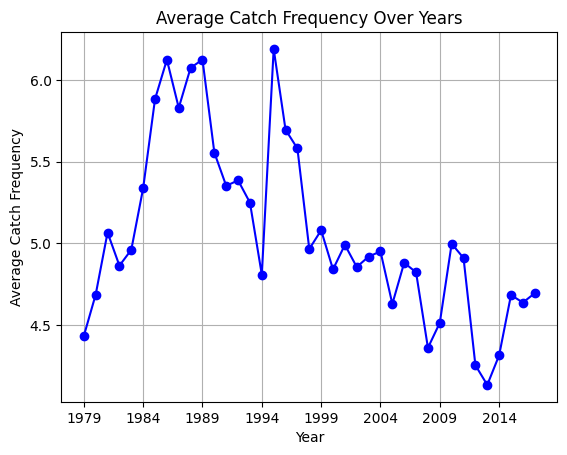

In [ ]:
dd = q1
dd = dd.toPandas()
plt.plot(dd['year'], dd['avg(catch_freq)'], marker='o', linestyle='-', color='b')


# Beautify the plot
plt.title('Average Catch Frequency Over Years')
plt.xlabel('Year')
plt.ylabel('Average Catch Frequency')
plt.xticks(dd['year'][::5])
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
q1 = spark.sql("SELECT common_name, year, AVG(catch_freq) FROM ABL_Survey GROUP BY common_name, year ORDER BY AVG(catch_freq) DESC")
dd = q1.toPandas()
dd = dd.dropna()
d2013 = dd[dd['year']=='2013']
d2013.head()

,common_name,year,avg(catch_freq)
33,Giant grenadier,2013,9.494922
98,Sablefish,2013,6.516701
106,Pacific cod,2013,6.350482
193,Skate Egg Case Unident.,2013,3.727273
198,Pacific grenadier,2013,3.647059


### Country - Catch freq

In [ ]:
q1 = spark.sql("SELECT country,  AVG(catch_freq), AVG(depth) , AVG(distance_fished), Count(*) FROM ABL_Survey GROUP BY country")
q1.show()

+-------------+-----------------+------------------+--------------------+--------+
|      country|  avg(catch_freq)|        avg(depth)|avg(distance_fished)|count(1)|
+-------------+-----------------+------------------+--------------------+--------+
|United States|5.065666347981982|415.72573479627897|   7.672272885398094| 1290722|
|        Japan| 5.20515405011524| 408.0037614678899|   7.697588880919921|  778805|
+-------------+-----------------+------------------+--------------------+--------+



In [ ]:
q1 = spark.sql("SELECT country,  year ,AVG(catch_freq), AVG(depth) , AVG(distance_fished), Count(*) FROM ABL_Survey WHERE country = 'United States' GROUP BY year, country ORDER BY year")
ml2 = q1
ml2 = ml2.toPandas()

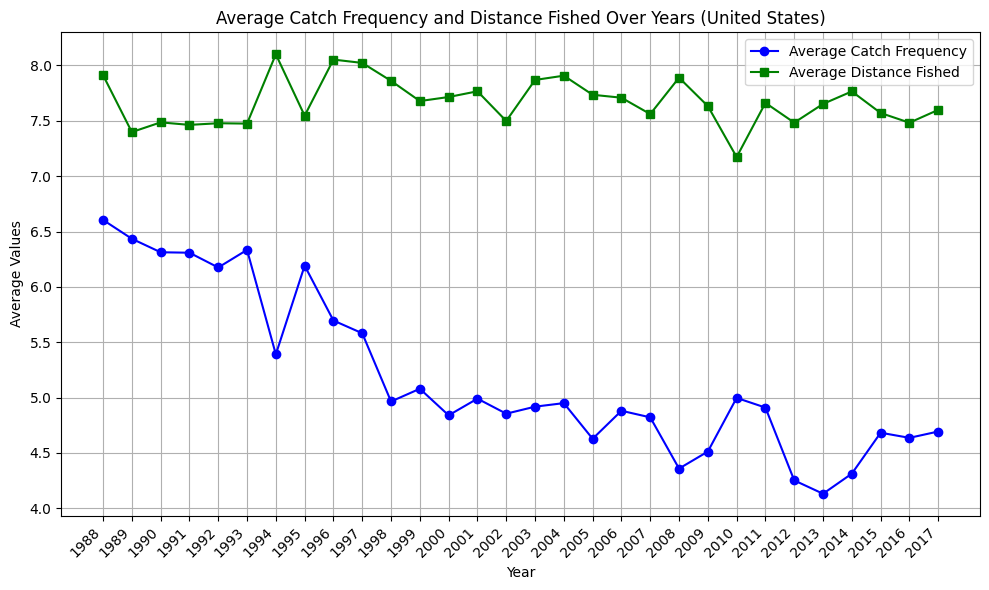

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(ml2['year'], ml2['avg(catch_freq)'], label='Average Catch Frequency', marker='o', linestyle='-', color='blue')
plt.plot(ml2['year'], ml2['avg(distance_fished)'], label='Average Distance Fished', marker='s', linestyle='-', color='green')

# Beautify the plot
plt.title('Average Catch Frequency and Distance Fished Over Years (United States)')
plt.xlabel('Year')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Values')
plt.legend()  # Add legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for better appearance

# Show the plot
plt.show()

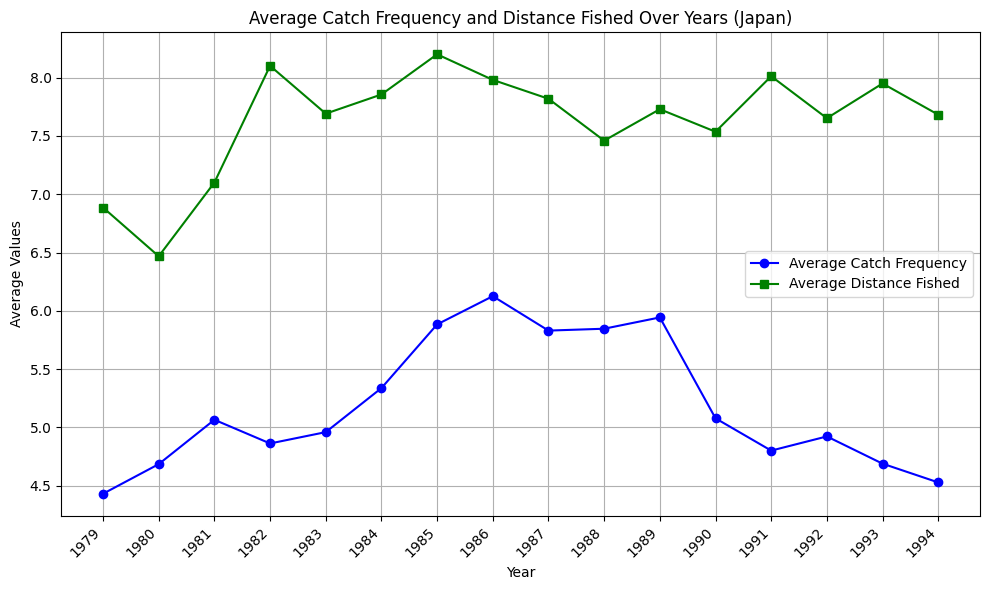

In [ ]:
q1 = spark.sql("SELECT country,  year ,AVG(catch_freq), AVG(depth) , AVG(distance_fished), Count(*) FROM ABL_Survey WHERE country = 'Japan' GROUP BY year, country ORDER BY year")
ml2 = q1
ml2 = ml2.toPandas()
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(ml2['year'], ml2['avg(catch_freq)'], label='Average Catch Frequency', marker='o', linestyle='-', color='blue')
plt.plot(ml2['year'], ml2['avg(distance_fished)'], label='Average Distance Fished', marker='s', linestyle='-', color='green')

# Beautify the plot
plt.title('Average Catch Frequency and Distance Fished Over Years (Japan)')
plt.xlabel('Year')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Values')
plt.legend()  # Add legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for better appearance

# Show the plot
plt.show()

In [ ]:
q1 = spark.sql("""
    SELECT *
    FROM (
        SELECT
            country,
            year,
            common_name,
            catch_freq,
            depth,
            distance_fished,
            ROW_NUMBER() OVER (PARTITION BY year ORDER BY catch_freq DESC) as row_num
        FROM
            ABL_Survey
        WHERE
            country = 'Japan'
    ) tmp
    WHERE
        row_num = 1
    ORDER BY
        year
""")
q1.show(30)

+-------+----+---------------+----------+-----+------------------+-------+
|country|year|    common_name|catch_freq|depth|   distance_fished|row_num|
+-------+----+---------------+----------+-----+------------------+-------+
|  Japan|1979|    Pacific cod|       9.0| null|               7.5|      1|
|  Japan|1980|    Pacific cod|       9.0| null|7.8000001907348633|      1|
|  Japan|1981|    Pacific cod|       9.0| null|5.1999998092651367|      1|
|  Japan|1982|    Pacific cod|       9.0|  330|               8.5|      1|
|  Japan|1983|      Sablefish|       9.0|  400|7.6999998092651367|      1|
|  Japan|1984|    Pacific cod|       9.0|  197|7.8000001907348633|      1|
|  Japan|1985|    Pacific cod|       9.0| null|               8.5|      1|
|  Japan|1986|    Pacific cod|       9.0| null|7.9000000953674316|      1|
|  Japan|1987|      Sablefish|       9.0|  165|7.1999998092651367|      1|
|  Japan|1988|      Sablefish|       9.0| null|7.5999999046325684|      1|
|  Japan|1989|      Sable

In [ ]:
q1 = spark.sql("""
    SELECT *
    FROM (
        SELECT
            country,
            year,
            common_name,
            catch_freq,
            depth,
            distance_fished,
            ROW_NUMBER() OVER (PARTITION BY year ORDER BY catch_freq DESC) as row_num
        FROM
            ABL_Survey
        WHERE
            country = 'United States'
    ) tmp
    WHERE
        row_num = 1
    ORDER BY
        year
""")
q1.show(30)

+-------------+----+-------------------+------------------+-----+------------------+-------+
|      country|year|        common_name|        catch_freq|depth|   distance_fished|row_num|
+-------------+----+-------------------+------------------+-----+------------------+-------+
|United States|1988|        Pacific cod|               9.0|  133|8.6000003814697266|      1|
|United States|1989|        Pacific cod|               9.0| null|4.3000001907348633|      1|
|United States|1990|          Sablefish|               9.0| null|8.6000003814697266|      1|
|United States|1991|          Sablefish|               9.0| null|8.6000003814697266|      1|
|United States|1992|        Pacific cod|               9.0| null|8.6000003814697266|      1|
|United States|1993|          Sablefish|               9.0| null|8.6000003814697266|      1|
|United States|1994|          Sablefish|               9.0| null|               9.5|      1|
|United States|1995|          Sablefish|               9.0| null|8.600

### Vessel / Station / Cruise

In [ ]:
#cruise_number, vessel_number, station_number, species_code, station_type, habitat_type
q1 = spark.sql("SELECT cruise_number, AVG(soak_time) , AVG(catch_freq) FROM ABL_Survey GROUP BY cruise_number ORDER BY AVG(catch_freq) DESC")
q1.show(50)

+-------------+------------------+------------------+
|cruise_number|    avg(soak_time)|   avg(catch_freq)|
+-------------+------------------+------------------+
|       199501|496.28687213683554| 6.191916727657152|
|       198901|429.63904343831354| 6.126395701050657|
|       198601| 528.5775346699744| 6.125988848406771|
|       198801|457.46521015603116|  6.07618456926516|
|       198501| 530.6277356230032| 5.883925718849841|
|       198701| 541.0155723070819|5.8308073794881965|
|       199601|426.49244452945675|  5.69639441469013|
|       199701| 457.2357262103506| 5.581457985531442|
|       199001|272.25021141248783| 5.556185235204281|
|       199201|244.47726047294694| 5.386137306469184|
|       199101|295.74322191600123|5.3523779238216385|
|       198401| 526.4969128791789| 5.337931319305346|
|       199301|250.53529462034783|   5.2494017860958|
|       199901| 526.0150147669303| 5.080092525661414|
|       198101|121.24855618502832| 5.066195478796546|
|       201001|489.032351346

In [ ]:
#cruise_number, vessel_number, station_number, species_code, station_type, habitat_type
q1 = spark.sql("SELECT vessel_number, AVG(soak_time) , AVG(catch_freq) FROM ABL_Survey GROUP BY vessel_number ORDER BY AVG(catch_freq) DESC")
q1.show(50)

+-------------+------------------+------------------+
|vessel_number|    avg(soak_time)|   avg(catch_freq)|
+-------------+------------------+------------------+
|           70| 487.8839100346021|6.6050832977360106|
|          523|  384.584702017832|  5.94367533096545|
|          561| 438.7475048572113|5.8468164724625336|
|          516| 510.8104776298778| 5.676933509135431|
|           81| 485.4963831485636|5.1998150700082295|
|          524|131.56607036251725| 5.078638038577928|
|          551|423.76585909447357| 4.966370191911024|
|          517|509.76572135712075| 4.960235124265236|
|          518|205.03549060542798| 4.937215333520412|
|           96|485.99970526573355| 4.817872760065916|
+-------------+------------------+------------------+



In [ ]:
#cruise_number, vessel_number, station_number, species_code, station_type, habitat_type
q1 = spark.sql("SELECT station_number, station_type ,AVG(soak_time) , AVG(catch_freq) FROM ABL_Survey GROUP BY station_number, station_type ORDER BY AVG(catch_freq) DESC")
q1.show(50)

+--------------+------------+------------------+------------------+
|station_number|station_type|    avg(soak_time)|   avg(catch_freq)|
+--------------+------------+------------------+------------------+
|           518|Experimental|             517.0| 9.093975903614458|
|           515|Experimental|431.94700460829495| 8.834101382488479|
|           529|Experimental|             509.0| 8.745721271393643|
|           517|Experimental|             570.0| 8.646929824561404|
|           519|Experimental|             502.0|  8.26963906581741|
|           528|Experimental|             539.0| 7.952488687782806|
|           507|Experimental|             179.0|  7.93609022556391|
|           512|Experimental| 633.3417721518987| 7.870886075949367|
|           527|Experimental|             578.0|  7.39963167587477|
|           530|Experimental|             552.0| 7.321428571428571|
|           516|Experimental|             559.0| 7.253731343283582|
|            70|    Standard|467.56233738537003|

In [ ]:
#cruise_number, vessel_number, station_number, species_code, station_type, habitat_type
q1 = spark.sql("SELECT species_code, common_name ,habitat_type,AVG(soak_time) , AVG(catch_freq) FROM ABL_Survey GROUP BY species_code, common_name, habitat_type ORDER BY AVG(catch_freq) DESC")
q1.show(50,truncate=False)

+------------+------------------------------------+-------------------------+------------------+------------------+
|species_code|common_name                         |habitat_type             |avg(soak_time)    |avg(catch_freq)   |
+------------+------------------------------------+-------------------------+------------------+------------------+
|20510       |Sablefish                           |Deep cross-shelf gully   |274.86151797603196|12.386669625684274|
|21220       |Pacific grenadier                   |Shallow cross-shelf gully|583.0             |10.088235294117647|
|21720       |Pacific cod                         |Upper continental slope  |391.5249416467497 |9.399983953035886 |
|20510       |Sablefish                           |Upper continental slope  |466.24142141965143|9.223259303801342 |
|20510       |Sablefish                           |Shallow cross-shelf gully|311.4361581507626 |8.366543844045523 |
|21230       |Giant grenadier                     |Upper continental slo

### Sablefish

In [ ]:
q1 = spark.sql(''' SELECT * FROM
            (SELECT year, AVG(catch_freq), AVG(soak_time),
                  ROW_NUMBER() OVER (PARTITION BY year ORDER BY year) as rwm
                    FROM ABL_Survey
                      WHERE common_name = "Sablefish"
                       GROUP BY year) WHERE rwm < 6
                          ''')
q1.show(100)

+----+------------------+------------------+---+
|year|   avg(catch_freq)|    avg(soak_time)|rwm|
+----+------------------+------------------+---+
|1979| 5.765933170334148|              null|  1|
|1980|6.0808707124010555|332.67044809982985|  1|
|1981| 7.551640759930915| 120.9608520437536|  1|
|1982| 7.448484359883908| 323.1000483714931|  1|
|1983| 7.736263736263736| 508.4717548076923|  1|
|1984| 8.665057526751951| 527.7028723147478|  1|
|1985|10.953646173969915| 531.6758502289077|  1|
|1986|11.150968273588793| 530.8498168498169|  1|
|1987| 9.965859714463067| 545.3102775560876|  1|
|1988| 11.49306804952905|  485.628202841686|  1|
|1989|11.037008066487411|464.98660296507904|  1|
|1990| 9.872452947581273| 312.8187898584539|  1|
|1991|10.376968613872444| 372.7084217580699|  1|
|1992|10.348877831886513|290.25582257040014|  1|
|1993|10.385379858657243|308.73669390459366|  1|
|1994| 8.549272326942699|318.24236077546857|  1|
|1995|10.419348546908523|507.23590793836553|  1|
|1996|10.11926690854

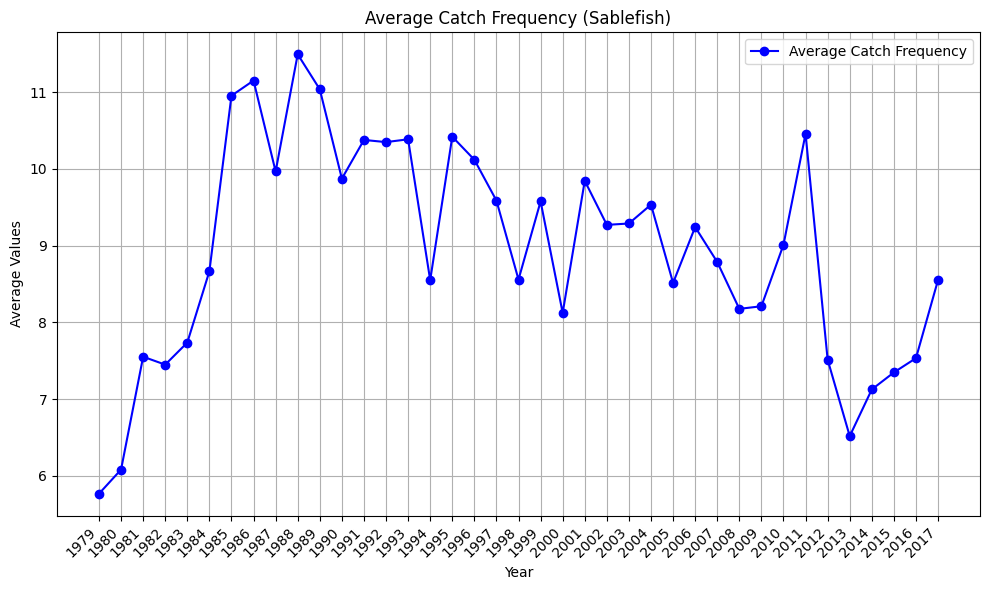

In [ ]:
# Plotting
ml2 = q1.toPandas()
plt.figure(figsize=(10, 6))

plt.plot(ml2['year'], ml2['avg(catch_freq)'], label='Average Catch Frequency', marker='o', linestyle='-', color='blue')
#plt.plot(ml2['year'], ml2['avg(distance_fished)'], label='Average Distance Fished', marker='s', linestyle='-', color='green')

# Beautify the plot
plt.title('Average Catch Frequency (Sablefish)')
plt.xlabel('Year')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Values')
plt.legend()  # Add legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for better appearance

# Show the plot
plt.show()

## Linear Regression model with features: Distance fished, Surface temp, soak time, starting depth, ending depth

In [ ]:
q1 = spark.sql("SELECT catch_freq, surface_temperature, distance_fished, soak_time, starting_depth, ending_depth FROM ABL_Survey WHERE surface_temperature IS NOT NULL AND soak_time IS NOT NULL")
q1.show()
ml1 = q1

+----------+-------------------+------------------+---------+--------------+------------+
|catch_freq|surface_temperature|   distance_fished|soak_time|starting_depth|ending_depth|
+----------+-------------------+------------------+---------+--------------+------------+
|       1.0|                7.5|4.3000001907348633|      654|           141|         327|
|      12.0|                7.5|4.3000001907348633|      654|           141|         327|
|       1.0|                7.5|4.3000001907348633|      654|           141|         327|
|       2.0|                7.5|4.3000001907348633|      654|           141|         327|
|       1.0|                7.5|4.3000001907348633|      654|           141|         327|
|      11.0|                7.5|4.3000001907348633|      654|           141|         327|
|       3.0|                7.5|4.3000001907348633|      654|           141|         327|
|      11.0|                7.5|4.3000001907348633|      654|           141|         327|
|       5.

In [ ]:
def parsePoint(row):
    catch_freq = float(row['catch_freq'])
    # Check if 'surface_temperature' is None and handle it accordingly
    surface_temperature = float(row['surface_temperature'])
    distance_fished = float(row['distance_fished'])
    soak_time = float(row['soak_time'])
    starting_depth = float(row['starting_depth'])
    ending_depth = float(row['ending_depth'])


    # Assuming 'catch_freq' is the label
    label = catch_freq
    features = ([surface_temperature,distance_fished,soak_time,starting_depth,ending_depth])

    return LabeledPoint(label, features)

In [ ]:
ml1 = ml1.rdd
ml1 = ml1.map(parsePoint)

In [ ]:
train, test = ml1.randomSplit([0.8, 0.2])

In [ ]:
model = LinearRegressionWithSGD.train(train, iterations=1000, step=0.000001)
predictions = test.map(lambda x: (x.label, model.predict(x.features)))
SE = predictions.map(lambda x: (x[0] - x[1])**2)
MSE = SE.reduce(lambda x, y: x + y) / predictions.count()
RMSE = sqrt(MSE)
print("Root Mean Squared Error = " + str(RMSE))

Root Mean Squared Error = 6.1384161547770875


## Random forest regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
q1 = spark.sql("SELECT catch_freq, surface_temperature, distance_fished, soak_time, starting_depth, ending_depth FROM ABL_Survey WHERE surface_temperature IS NOT NULL AND soak_time IS NOT NULL")
q1.show()
ml1 = q1

+----------+-------------------+---------------+---------+--------------+------------+
|catch_freq|surface_temperature|distance_fished|soak_time|starting_depth|ending_depth|
+----------+-------------------+---------------+---------+--------------+------------+
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      12.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       2.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      11.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       3.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      11.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       5.0|                7.5|           

In [ ]:
ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
#ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
#ml1 = ml1.withColumn("year", col("year").cast("float"))
ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
ml1 = ml1.withColumn("surface_temperature", col("surface_temperature").cast("float"))

In [ ]:
# Preparing the data
feature_columns = ["surface_temperature", "distance_fished", "soak_time", "starting_depth", "ending_depth"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(ml1)

# Selecting features and target variable
data = df_assembled.select("features", "catch_freq")

# Splitting the data into training and testing sets
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)

# Defining the Random Forest Regression model
rf = RandomForestRegressor(labelCol="catch_freq", featuresCol="features")

# Training the model
model = rf.fit(train_data)

# Making predictions on the test set
predictions = model.transform(test_data)

# Evaluating the model
evaluator = RegressionEvaluator(labelCol="catch_freq", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 5.950586046227268


## GBT Regressor

In [ ]:
q1 = spark.sql("SELECT catch_freq, surface_temperature, distance_fished, soak_time, starting_depth, ending_depth FROM ABL_Survey WHERE surface_temperature IS NOT NULL AND soak_time IS NOT NULL")
q1.show()
ml1 = q1

+----------+-------------------+---------------+---------+--------------+------------+
|catch_freq|surface_temperature|distance_fished|soak_time|starting_depth|ending_depth|
+----------+-------------------+---------------+---------+--------------+------------+
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      12.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       2.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      11.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       3.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      11.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       5.0|                7.5|           

In [ ]:
ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
#ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
#ml1 = ml1.withColumn("year", col("year").cast("float"))
ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
ml1 = ml1.withColumn("surface_temperature", col("surface_temperature").cast("float"))

In [ ]:

feature_columns = ["surface_temperature", "distance_fished", "soak_time", "starting_depth", "ending_depth"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(ml1)


data = df_assembled.select("features", "catch_freq")

(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)


gbt = GBTRegressor(labelCol="catch_freq", featuresCol="features", maxIter=10)


model = gbt.fit(train_data)

# Making predictions on the test set
predictions = model.transform(test_data)

# Evaluating the model
evaluator = RegressionEvaluator(labelCol="catch_freq", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 5.925700192046256


## Generalized Linear Regression

In [ ]:
q1 = spark.sql("SELECT catch_freq, surface_temperature, distance_fished, soak_time, starting_depth, ending_depth FROM ABL_Survey WHERE surface_temperature IS NOT NULL AND soak_time IS NOT NULL")
q1.show()
ml1 = q1

+----------+-------------------+---------------+---------+--------------+------------+
|catch_freq|surface_temperature|distance_fished|soak_time|starting_depth|ending_depth|
+----------+-------------------+---------------+---------+--------------+------------+
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      12.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       2.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       1.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      11.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       3.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|      11.0|                7.5|            4.3|    654.0|         141.0|       327.0|
|       5.0|                7.5|           

In [ ]:
ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
#ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
#ml1 = ml1.withColumn("year", col("year").cast("float"))
ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
ml1 = ml1.withColumn("surface_temperature", col("surface_temperature").cast("float"))

In [ ]:

feature_columns = ["surface_temperature", "distance_fished", "soak_time", "starting_depth", "ending_depth"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(ml1)


data = df_assembled.select("features", "catch_freq")


(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=1234)


glr = GeneralizedLinearRegression(labelCol="catch_freq", featuresCol="features", family="gaussian", link="identity")


model = glr.fit(train_data)


predictions = model.transform(test_data)


evaluator = RegressionEvaluator(labelCol="catch_freq", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 5.9895818598364325


## Correlation analysis

In [ ]:
q1 = spark.sql("SELECT * FROM ABL_Survey")
ml1 = q1

In [ ]:
ml1 = ml1.withColumn("distance_fished", col("distance_fished").cast("float"))
ml1 = ml1.withColumn("catch_freq", col("catch_freq").cast("float"))
#ml1 = ml1.withColumn("hachi", col("hachi").cast("float"))
ml1 = ml1.withColumn("year", col("year").cast("float"))
ml1 = ml1.withColumn("soak_time", col("soak_time").cast("float"))
ml1 = ml1.withColumn("starting_depth", col("starting_depth").cast("float"))
ml1 = ml1.withColumn("ending_depth", col("ending_depth").cast("float"))
ml1 = ml1.withColumn("surface_temperature", col("surface_temperature").cast("float"))
ml1 = ml1.withColumn("haul_date", col("haul_date").cast(TimestampType()))

In [ ]:
correlation_result = ml1.stat.corr("soak_time", "catch_freq")

print(f"Correlation between 'distance_fished' and 'catch_freq': {correlation_result}")

Correlation between 'distance_fished' and 'catch_freq': 0.06229893640134641
